In [1]:
from data_processing.data_loader import load_music_tags_dataset, load_audio_data, process_audio_in_parallel
from data_processing.labels_processing import preprocess_labels
from data_processing.data_loader import process_audio_to_melspectrogram
from data_processing.data_loader import convert_spectrogram_image_to_mel
from data_processing.data_loader import process_images_in_parallel

Для удобства процессинга признаков, возьму спектограммы, в который я уверена - те, что мы сами получаем из аудио.

In [2]:
# dataset = load_music_tags_dataset()  # For built-in dataset
audio_files, labels = load_audio_data("Data/genres_original")

In [3]:
n_processes = 16
# built_in_spects = process_images_in_parallel(dataset['train'], n_processes=n_processes)
mel_spectrograms = process_audio_in_parallel(audio_files[:], labels[:], n_processes=n_processes)

Processing audios: 100%|█████████████████████████████| 1000/1000 [00:29<00:00, 34.37file/s]


Error reading Data/genres_original/jazz/jazz.00054.wav: Error opening 'Data/genres_original/jazz/jazz.00054.wav': Format not recognised.


Удаляем проблемные файлы.

In [4]:
mel_spectrograms = [spec for spec in mel_spectrograms if spec]
print(len(mel_spectrograms))

13978


Перемешиваю данные - здесь пока делаю вручную, чтобы было лучше видно, с какими данными работаем - поскольку в задаче классификации львиная доля работы заключается в обработке признаков, не собираем все в пайплайн, а последовательно применяем функции.

In [6]:
import numpy as np
np.random.seed(42)

all_indices = np.arange(len(mel_spectrograms))
np.random.shuffle(all_indices)

train_index = all_indices[:int(len(mel_spectrograms) * 0.6)]
test_index = np.setdiff1d(np.arange(len(mel_spectrograms)), train_index)

ds_train = [mel_spectrograms[i] for i in train_index]
ds_test = [mel_spectrograms[i] for i in test_index]

Данные совсем разношерстны - вручную разделяем жанры и ищем самые популярные.

In [9]:
genre_map = {
    # Pop
    '60s': 'pop', '70s': 'pop', '80s': 'pop', '90s': 'pop',
    'advertising': 'pop', 'commercial': 'pop', 'corporate': 'pop',
    'dance': 'pop', 'disco': 'pop', 'electropop': 'pop',
    'instrumentalpop': 'pop', 'party': 'pop', 'pop': 'pop',
    'popfolk': 'pop', 'poprock': 'pop', 'positive': 'pop',
    'retro': 'pop', 'synthpop': 'pop',
    
    # Rock
    'alternativerock': 'rock', 'grunge': 'rock', 'hardrock': 'rock',
    'instrumentalrock': 'rock', 'metal': 'rock', 'postrock': 'rock',
    'progressive': 'rock', 'psychedelic': 'rock', 'punkrock': 'rock',
    'rock': 'rock', 'rocknroll': 'rock',
    
    # Hip-Hop / R&B
    'beat': 'rb', 'breakbeat': 'rb', 'drumnbass': 'rb', 'dubstep': 'rb',
    'electronic': 'rb', 'funk': 'rb', 'hiphop': 'rap', 'house': 'rb',
    'rnb': 'rb', 'rap': 'rap', 'soul': 'rb', 'triphop': 'rb',
    
    # Jazz / Blues
    'acidjazz': 'jazz', 'blues': 'jazz', 'bossanova': 'jazz',
    'fusion': 'jazz', 'jazz': 'jazz', 'jazzfunk': 'jazz',
    'lounge': 'jazz', 'swing': 'jazz',
    
    # Classical
    'accordion': 'classical', 'ambient': 'classical', 'ambiental': 'classical',
    'cello': 'classical', 'choir': 'classical', 'classical': 'classical',
    'classicalguitar': 'classical', 'flute': 'classical', 'harp': 'classical',
    'medieval': 'classical', 'orchestra': 'classical', 'orchestral': 'classical',
    'organ': 'classical', 'piano': 'classical', 'pipeorgan': 'classical',
    'strings': 'classical', 'symphonic': 'classical', 'viola': 'classical',
    'violin': 'classical',
    
    # Country / Folk
    'acousticbassguitar': 'country', 'acousticguitar': 'country',
    'banjo': 'country', 'ballad': 'country', 'country': 'country',
    'folk': 'country', 'harmonica': 'country', 'singersongwriter': 'country',
    'ukulele': 'country',
    
    # Electronic / EDM
    'deephouse': 'electronic', 'edm': 'electronic', 'eurodance': 'electronic',
    'minimal': 'electronic', 'newwave': 'electronic', 'synthesizer': 'electronic',
    'techno': 'electronic', 'trance': 'electronic',
    
    # World Music
    'african': 'world', 'bongo': 'world', 'celtic': 'world', 'ethno': 'world',
    'latin': 'world', 'oriental': 'world', 'reggae': 'world', 'ska': 'world',
    'tribal': 'world', 'world': 'world', 'worldfusion': 'world',
    
    # Soundtrack / Atmospheric
    'action': 'soundtrack', 'adventure': 'soundtrack', 'background': 'soundtrack',
    'calm': 'soundtrack', 'cinematic': 'soundtrack', 'documentary': 'soundtrack',
    'drama': 'soundtrack', 'dramatic': 'soundtrack', 'epic': 'soundtrack',
    'film': 'soundtrack', 'hopeful': 'soundtrack', 'melancholic': 'soundtrack',
    'meditative': 'soundtrack', 'motivational': 'soundtrack', 'movie': 'soundtrack',
    'nature': 'soundtrack', 'newage': 'soundtrack', 'romantic': 'soundtrack',
    'sad': 'soundtrack', 'soundscape': 'soundtrack', 'soundtrack': 'soundtrack',
    'space': 'soundtrack', 'sport': 'soundtrack', 'trailer': 'soundtrack',
    'travel': 'soundtrack',
}

common_genres = ['pop', 'rock', 'rb', 'rap', 'jazz', 'classical', 'country', 'electronic', 'world', 'soundtrack']

Достанем-ка еще валидационную выборку для удобства наблюдения прогресса при обучении.

In [10]:
y_train, y_test, mlb = preprocess_labels(ds_train, ds_test, genre_map, common_genres)

X_train = [item[0] for item in ds_train]
X_val = [item[0] for item in ds_test[:int(len(ds_test) * 0.5)]]
X_test = [item[0] for item in ds_test[int(len(ds_test) * 0.5):]]

y_val = y_test[int(len(y_test) * 0.5):]
y_test = y_test[:int(len(y_test) * 0.5)]

print("Features:")
n = len(X_train) + len(X_val) + len(X_test)
print(f"{round(len(X_train) / n * 100)}%/{round(len(X_val) / n * 100)}%/{round(len(X_test) / n * 100)}%")

print("Labels:")
n = len(y_train) + len(y_val) + len(y_test)
print(f"{round(len(y_train) / n * 100)}%/{round(len(y_val) / n * 100)}%/{round(len(y_test) / n * 100)}%")

Features:
60%/20%/20%
Labels:
60%/20%/20%


In [11]:
from data_processing.data_loader import SpectrogramDataset
import torch
from torch.utils.data import DataLoader
from model.model import SpectrogramCNN, train_model, evaluate_model

img_size = (128, 128)
train_dataset = SpectrogramDataset(X_train, y_train, img_size=img_size, augment=True)
test_dataset = SpectrogramDataset(X_test, y_test, img_size=img_size)
val_dataset = SpectrogramDataset(X_val, y_val, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8

Продемонстрируем ниже чудеса аугментации тренировочных данных, это необходимо для избежания переобучения.

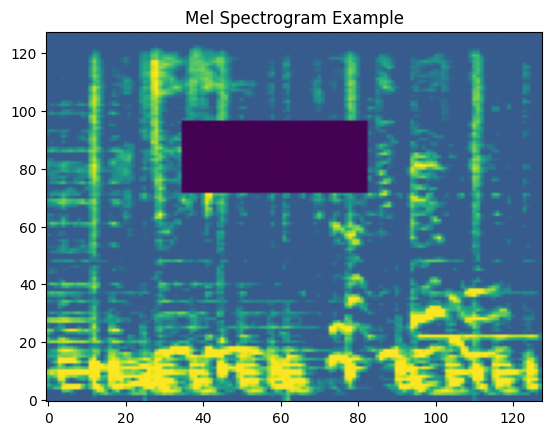

In [53]:
test = train_loader.dataset[1][0]
import matplotlib.pyplot as plt

plt.imshow(test[0], aspect='auto', origin='lower', cmap='viridis')
plt.title("Mel Spectrogram Example")
plt.show()

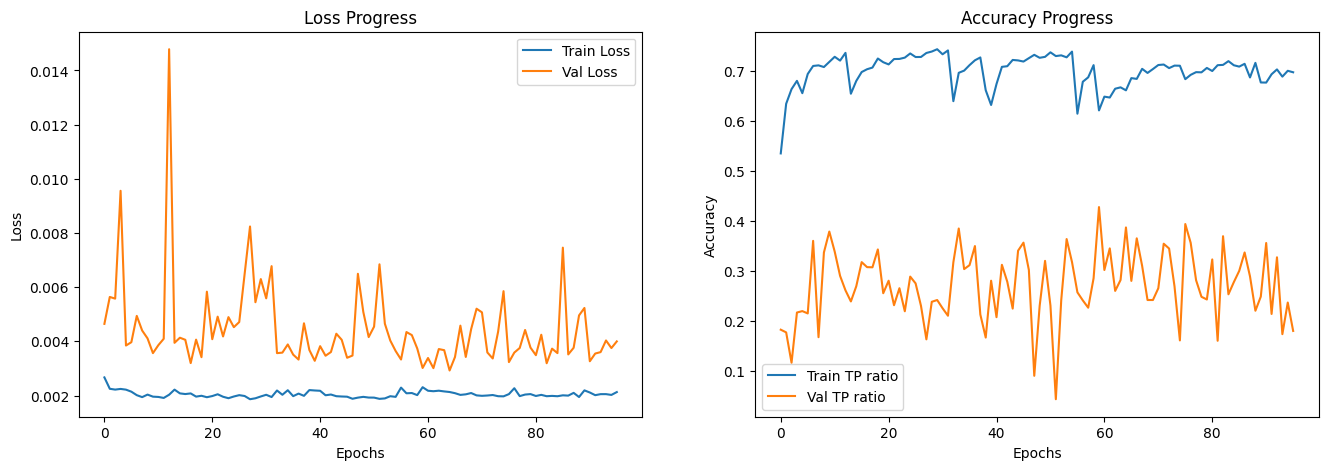

Training Progress: 100%|███████████████████████████████| 100/100 [1:01:57<00:00, 37.17s/it]


In [15]:
num_classes = len(mlb)
model = SpectrogramCNN(num_classes)

model = train_model(model, train_loader, val_loader, y_train, num_epochs=100, lr=0.01, w_d=1e-4,
                    device='mps')


Проверяем, что на тренировочной выборке есть продвижения.

In [16]:
import pandas as pd

y_true_1, y_pred_1 = evaluate_model(model, train_loader, pd.Series(mlb).to_frame('classes_'), device='mps')

Classification Report:
               precision    recall  f1-score   support

   classical       0.30      0.99      0.46       839
     country       0.26      0.14      0.18       832
        jazz       0.30      0.80      0.43      1667
         pop       0.63      0.55      0.59      1693
         rap       0.94      0.13      0.23       818
        rock       0.54      0.56      0.55      1701
       world       0.77      0.20      0.32       836

   micro avg       0.39      0.53      0.45      8386
   macro avg       0.53      0.48      0.39      8386
weighted avg       0.52      0.53      0.43      8386
 samples avg       0.42      0.53      0.45      8386

Accuracy: 0.3119


/Users/ruaboeq/Desktop/HSE/1_year_project/Music-Predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Внизу немного накосячила с тестовой выборкой, но видно, что попадающие классы, распознаются довольно хорошо. Здесь лучше оценивать прогресси по валидационной выборке - и прогресс виден, и способность к обучению в принципе, чего было совсем непросто добиться :)

In [46]:
import pandas as pd

y_true_2, y_pred_2 = evaluate_model(model, test_loader, pd.Series(mlb).to_frame('classes_'), device='mps')

Classification Report:
               precision    recall  f1-score   support

   classical       0.01      0.90      0.02        20
     country       0.00      0.00      0.00         0
        jazz       0.26      0.68      0.37       545
         pop       0.86      0.23      0.36      1106
         rap       0.00      0.00      0.00         0
        rock       0.43      0.23      0.30       563
       world       0.00      0.00      0.00       561

   micro avg       0.21      0.28      0.24      2795
   macro avg       0.22      0.29      0.15      2795
weighted avg       0.48      0.28      0.28      2795
 samples avg       0.21      0.28      0.23      2795

Accuracy: 0.1503


/Users/ruaboeq/Desktop/HSE/1_year_project/Music-Predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ruaboeq/Desktop/HSE/1_year_project/Music-Predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
